In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display
import numpy as np

from src.data import NSynthDataset

/home/ec2-user/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [18]:
inpt = np.random.rand(8, 1, 128, 251)
#inpt = np.random.rand(8, 1, 40, 126)

In [85]:
h_dim = 128

conv1 = nn.Conv2d(1, 32, 4, padding=(1, 4), stride=(2, 2))
conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
conv5 = nn.Conv2d(256, 512, 4, padding=1, stride=(2, 2))

fc_enc = nn.Linear(512*4*8, h_dim, bias=True)
fc_dec = nn.Linear(h_dim, 512*4*8, bias=True)

deconv1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
deconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
deconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
deconv4 = nn.ConvTranspose2d(64, 32, 2, stride=2)
deconv5 = nn.ConvTranspose2d(32, 1, (2, 3), padding=(0, 3), stride=2)

In [86]:
h = conv1(torch.tensor(inpt, dtype=torch.float32))
h = conv2(h)
h = conv3(h)
h = conv4(h)
h = conv5(h)

h = fc_enc(h.view(h.size(0), -1))
h = fc_dec(h)

h = deconv1(h.view(h.size(0), 512, 4, 8))
h = deconv2(h)
h = deconv3(h)
h = deconv4(h)
h = deconv5(h)
print(h.size())

torch.Size([8, 1, 128, 251])


In [33]:
h.size()

torch.Size([8, 512, 4, 8])

In [34]:
512*4*8

16384

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, h_dim=128):
        super(Autoencoder, self).__init__()
        
        # (1, 128, 251)
        self.conv1 = nn.Conv2d(1, 32, 4, padding=(1, 4), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
        self.conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
        self.conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
        self.conv5 = nn.Conv2d(256, 512, 4, padding=1, stride=(2, 2))

        self.fc_enc = nn.Linear(512*4*8, h_dim, bias=True)
        self.fc_dec = nn.Linear(h_dim, 512*4*8, bias=True)

        self.deconv1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.deconv5 = nn.ConvTranspose2d(32, 1, (2, 3), padding=(0, 3), stride=2)
        
        # (1, 40, 126)
#         self.conv1 = nn.Conv2d(1, 32, 4, padding=1, stride=(2, 2))
#         self.conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
#         self.conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
#         self.conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
        
#         self.fc_enc = nn.Linear(3584, h_dim, bias=True)
#         self.fc_dec = nn.Linear(h_dim, 3584, bias=True)

#         self.deconv1 = nn.ConvTranspose2d(256, 128, 3, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 3), stride=2)
#         self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 3), stride=2)
#         self.deconv4 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
    
        x = x.view(x.size(0), -1)
        return F.relu(self.fc_enc(x))
        
    def decode(self, z):
        h = F.relu(self.fc_dec(z))
        h = h.view(h.size(0), 512, 4, 8)
        
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        h = F.relu(self.deconv3(h))
        h = F.relu(self.deconv4(h))
        h = self.deconv5(h)
        return torch.sigmoid(h)
        
    def forward(self, x):
        z = self.encode(x)
        outputs = self.decode(z)
        return outputs

In [10]:
hparams = {
    'feature_type' : 'mel',
    'instrument_source' : [0],
    'scaling' : 'normalize',
    'n_epochs' : 25,
    'batch_size' : 32,
    'lr' : 0.001,
    'hidden_dim' : 128,
    'display_iters' : 10,
    'val_iters' : 100,
    'n_val_samples' : 1000
}

In [11]:
train_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-train', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling']
)

val_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-valid', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling']
)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [13]:
model = Autoencoder(h_dim=hparams['hidden_dim'])

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

[0,    10] loss : 0.0764
[0,    20] loss : 0.0415
[0,    30] loss : 0.0281
[0,    40] loss : 0.0228
[0,    50] loss : 0.0247
[0,    60] loss : 0.0167
[0,    70] loss : 0.0243
[0,    80] loss : 0.0209
[0,    90] loss : 0.0133
[0,   100] loss : 0.0183
Val - loss : 0.0272


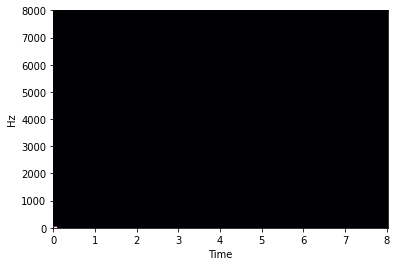

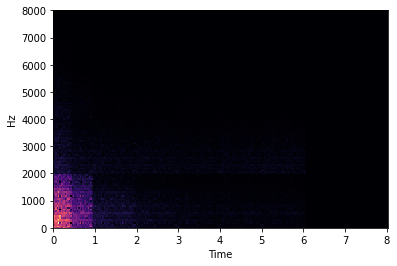

[0,   110] loss : 0.0214
[0,   120] loss : 0.0142
[0,   130] loss : 0.0171
[0,   140] loss : 0.0214
[0,   150] loss : 0.0177
[0,   160] loss : 0.0122
[0,   170] loss : 0.0167
[0,   180] loss : 0.0128
[0,   190] loss : 0.0159
[0,   200] loss : 0.0154
Val - loss : 0.0222


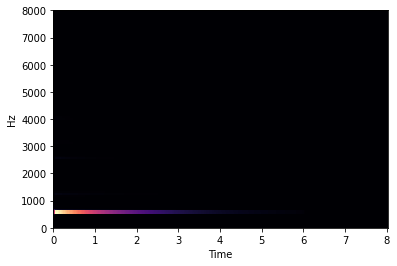

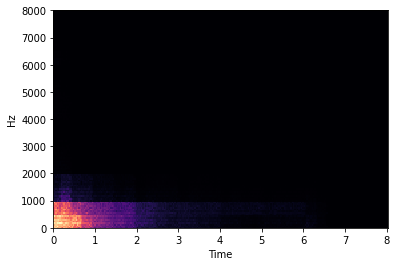

[0,   210] loss : 0.0112
[0,   220] loss : 0.0148
[0,   230] loss : 0.0204
[0,   240] loss : 0.0107
[0,   250] loss : 0.0173
[0,   260] loss : 0.0075
[0,   270] loss : 0.0196
[0,   280] loss : 0.0143
[0,   290] loss : 0.0108
[0,   300] loss : 0.0171
Val - loss : 0.0211


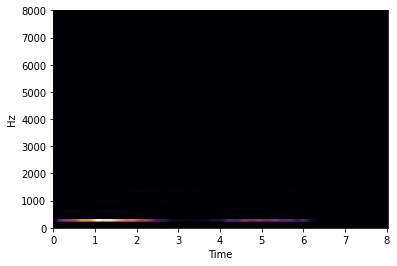

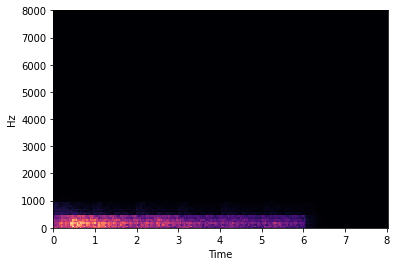

[0,   310] loss : 0.0179
[0,   320] loss : 0.0142
[0,   330] loss : 0.0190
[0,   340] loss : 0.0118
[0,   350] loss : 0.0175
[0,   360] loss : 0.0140
[0,   370] loss : 0.0144
[0,   380] loss : 0.0112
[0,   390] loss : 0.0185
[0,   400] loss : 0.0124
Val - loss : 0.0204


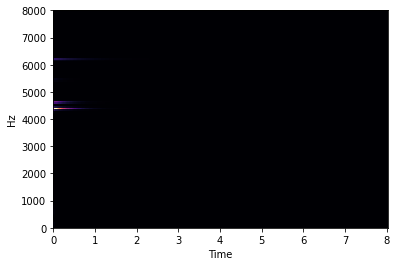

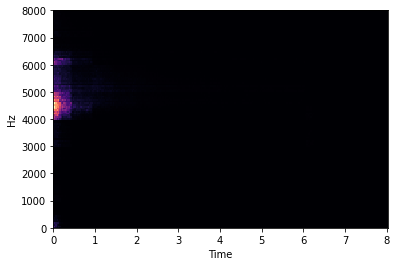

[0,   410] loss : 0.0133
[0,   420] loss : 0.0177
[0,   430] loss : 0.0108


KeyboardInterrupt: 

In [15]:
loss_fn = nn.BCELoss()

for epoch in range(hparams['n_epochs']):
    itr = 0
    for batch in train_dataloader:
        itr += 1
        batch = batch.unsqueeze(1)
        outputs = model(batch)
        
        loss = loss_fn(outputs, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if itr % hparams['display_iters'] == 0:
            print('[{}, {:5d}] loss : {:.4f}'.format(epoch, itr, loss.item()))
            
        if itr % hparams['val_iters'] == 0:
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)
            
            model.eval()
            
            ct, i, val_loss = 0, 0, 0.0
            for batch in val_dataloader:
                i += 1
                ct += batch.size(0)
                batch = batch.unsqueeze(1)
                outputs = model(batch)
                
                loss = loss_fn(outputs, batch)
                val_loss += (loss.item() - val_loss)/i
                
                if ct >= hparams['n_val_samples']:
                    break
            
            print('Val - loss : {:.4f}'.format(val_loss))
            librosa.display.specshow(batch[0][0].numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            librosa.display.specshow(outputs[0][0].detach().numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
                    
            model.train()